### Pysal子模块esda《官方文档》
- Pysal项目的一个子模块（esda），专注于整体与局部的空间自相关分析

#### 柏林房价案例

In [1]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
#房价datafram转换geodataframe
gdf = gpd.read_file('example_data/berlin-neighbourhoods.geojson')
bl_df = pd.read_csv('example_data/berlin-listings.csv')
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]
bl_gdf = GeoDataFrame(bl_df, crs="EPSG:4326", geometry=geometry)

In [3]:
#空间合并，房价geodataframe和矢量边界geodataframe合并
#按照neighbourhood_group分组，计算每个分组的平均房价
bl_gdf['price'] = bl_gdf['price'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()

In [4]:
#将分组后平均房价dataseries添加到矢量边界geodataframe，对价格那一列重命名
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)

2


/var/folders/my/kd1_1rw50f17rtwxs6h8dwk80000gn/T/ipykernel_3224/4100548338.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)


<Axes: >

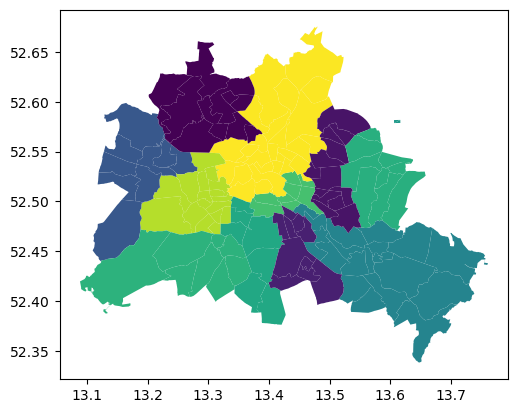

In [5]:
#填补缺失值，绘制一个简易示意图
print(pd.isnull(gdf['median_pri']).sum())
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)
gdf.plot(column='median_pri')

<Axes: >

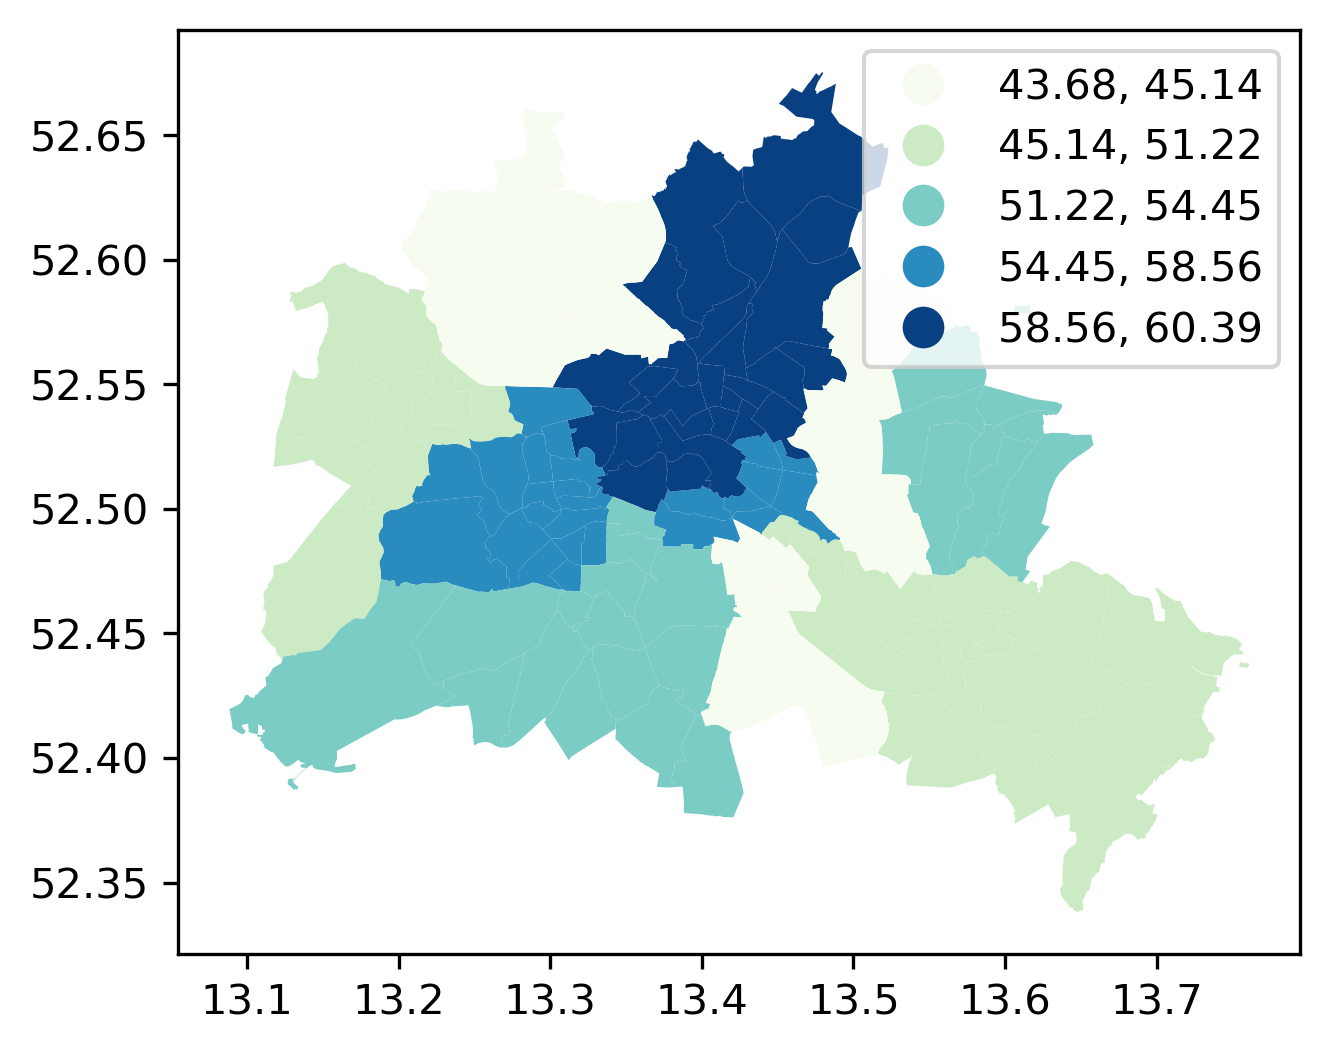

In [6]:
#美化一下这个示例图
fig, ax = plt.subplots(figsize=(5,4),dpi=300, subplot_kw={'aspect':'equal'})
gdf.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)

##### 前处理完成，进行空间相似性分析
1. 空间（邻接）权重
2. 属性相似度（空间滞后）

In [7]:
#transform 属性用于指定如何转换权重矩阵的值。
# r(行标准化):将权重矩阵的每一行除以该行的权重总和，使得每一行的权重之和为1。
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/var/folders/my/kd1_1rw50f17rtwxs6h8dwk80000gn/T/ipykernel_3224/2756119717.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/Users/wangling/miniconda3/envs/geoproject/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [8]:
#计算空间滞后
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)

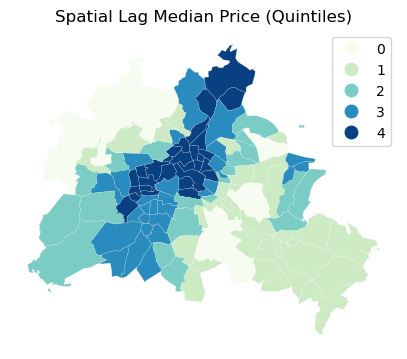

In [9]:
#mapclassify.Quantiles()用于将空间滞后值分为五个等级，绘图
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)
f, ax = plt.subplots(1, figsize=(5, 5))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")
plt.show()

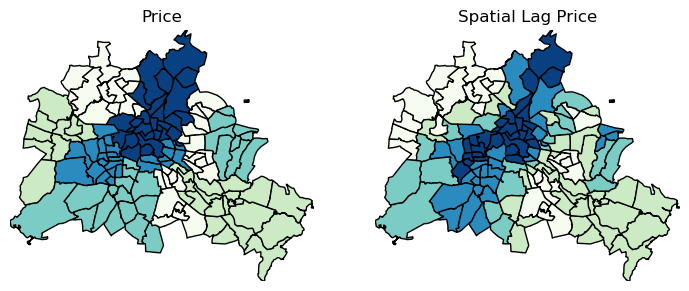

In [10]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")

df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

##### 全局空间自相关

In [11]:
#查看房价均值，并进行二元分类得到yb属性
y.median()
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
df['yb'] = yb

<Axes: >

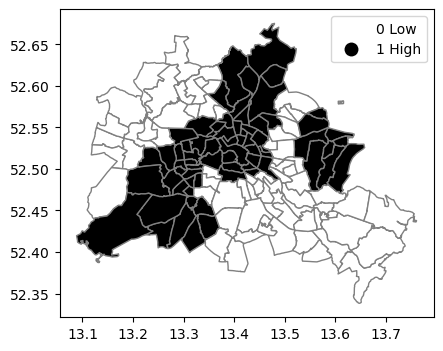

In [12]:
#用yb的二元分类简单绘制可视化图
fig, ax = plt.subplots(figsize=(6,4), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

##### 连接计数以计算空间自相关
- 每个单元可以采用“黑色”或“白色”两个值之一，因此对于给定的一对相邻位置，只可能出现三种不同类型的连接（加合为全局）：

> 黑色 黑色 (BB)
> 
> 白色 白色 (WW)
> 
> 黑白（或白黑）（BW）

- 使用esdaPySAL 中的包来进行连接计数分析（以帮助理解空间数据中是否存在聚集模式）

In [13]:
'''
这里的'b'代表的是二元化binary transformation。
在应用这种转换后,权重矩阵中的所有非零值都将被设置为1,而零值保持不变.
简单来说,就是将原始的权重值转化为是否存在连接的关系,而不考虑连接强度的具体数值差异.
'''
import esda
y = df['median_pri']
#二值“与门”
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
#二值化后的用于计算连接计数的类Join_Counts
jc = esda.join_counts.Join_Counts(yb, wq)

/var/folders/my/kd1_1rw50f17rtwxs6h8dwk80000gn/T/ipykernel_3224/68114378.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/Users/wangling/miniconda3/envs/geoproject/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [14]:
#利用类的实例化jc对象的属性，查看不同类型的连接计数
jc.bb
jc.ww
jc.bw
jc.J==jc.bb+jc.ww+jc.bw

True

- 现在问题来了：如果生成黑色多边形的空间分布的过程是完全随机的，这是否与我们的预期背道而驰？

esda基于空间数据中的值是完全随机分布的假设(零假设)，使用观察到的属性值的随机空间排列来生成完全空间随机性(CSR) 下的实现。这重复了很多次（默认为 999 次）以构建参考分布，以评估我们观察到的计数的统计显着性。

有助于评估实际观察到的空间模式是否偏离了随机分布

In [15]:
#利用Join_Counts封装的mean_xx属性
jc.mean_bb
jc.mean_bw

193.94794794794794

- 这比我们观察到的计数要小。问题是我们的观察值是否与预期值相差太大，以至于我们要拒绝 CSR 的零假设

Text(0.5, 0, 'BB Counts')

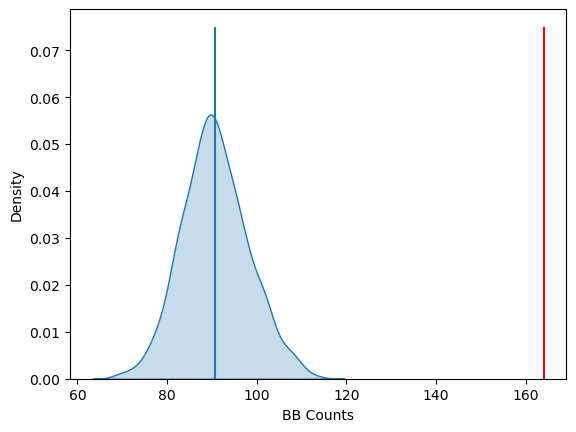

In [16]:
'''
jc.sim_bb: 这是Join_Counts对象的一个属性,包含了多次模拟下得到的黑-黑连接计数;
这些模拟基于随机分配的空间模式（零假设）,用来生成一个关于黑-黑连接可能分布的概率密度估计
'''
import seaborn as sbn
#kdeplot用于绘制一维或二维数据集的核密度估计（KDE）图
sbn.kdeplot(jc.sim_bb, fill=True)
plt.vlines(jc.bb, 0, 0.075, color='r') #vlines添加垂直线
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

- esda模拟的核概率密度图描绘了 BB 计数的分布，黑色垂直线表示合成实现的平均 BB 计数，红线表示我们价格的观测 BB 计数。显然，我们的观测值非常高。伪 p 值总结了这一点

In [17]:
#由于这远低于传统的显著性水平，
#我们将拒绝完全空间随机性的零假设，而支持柏林房价市场价格的空间自相关性
jc.p_sim_bb 

0.001

然而，如上流程只基于二值（0/1）属性，却丢弃了原本连续的属性中的大量信息
- Moran's I （莫兰）是针对连续属性的全局自相关的检验
- 回到原始变量，我们可以探索连续情况下的其他空间自相关性测试
> 全局莫兰指数的值域范围在 -1 到 1 之间：

>如果 Moran's I > 0，则表示存在正的空间自相关性，意味着相似的值倾向于聚集在一起；

> 如果 Moran's I < 0，则表示存在负的空间自相关性，意味着高值和低值倾向于相互间隔开；

> 如果 Moran's I = 0，则表示没有显著的空间自相关性，或者说数据呈现出随机分布的状态。

In [18]:
#首先，我们将权重从当前二进制状态转换为行标准化
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'
y = df['median_pri']
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

/var/folders/my/kd1_1rw50f17rtwxs6h8dwk80000gn/T/ipykernel_3224/3511941715.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/Users/wangling/miniconda3/envs/geoproject/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


0.6563069331329718

- 事实上，莫兰指数（类）和上述Join_Counts（类）一样都有基于CSR的原假设的蒙特卡洛模拟，都可以构建参考分布

Text(0.5, 0, "Moran's I")

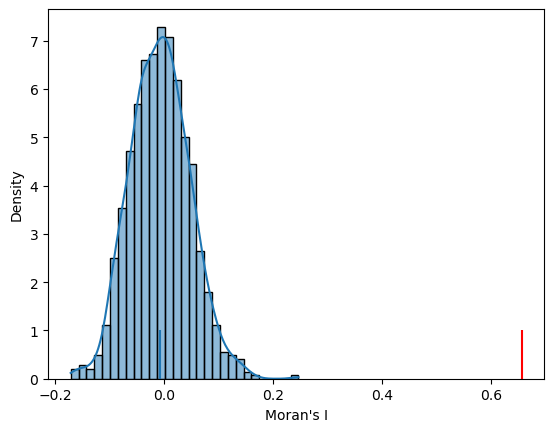

In [19]:
import seaborn as sbn
#sbn.kdeplot(mi.sim, fill=True)
sbn.histplot(mi.sim, stat="density", kde=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

- 在这里，我们的观测值再次出现在上尾，尽管从视觉上看，它相对于二进制情况来说并不极端。然而，它仍然具有统计意义（拒绝CSR原假设）

In [20]:
#基于蒙特卡洛模拟的p值
#用于评估观测到的全局莫兰指数是否显著不同于CSR分布下的期望值。
mi.p_sim

0.001

##### 局部自相关：热点、冷点和空间异常值
除了全局自相关统计数据外，PySAL 还有许多局部自相关统计数据,比如局部Moran 统计量

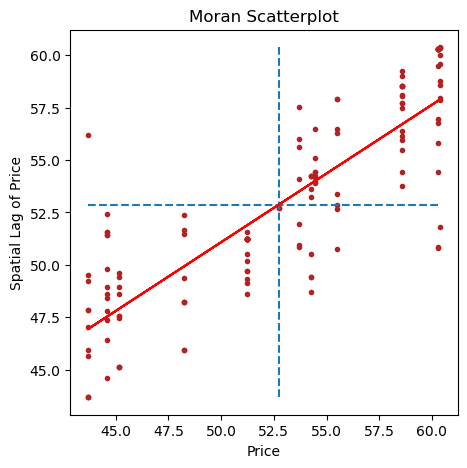

In [21]:
import esda
np.random.seed(12345)
#计算空间延迟
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['median_pri'])
#绘图
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(5, 5))
plt.plot(price, lag_price, '.', color='firebrick')
 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')
# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

- 局部莫兰指数和全局莫兰指数一样，都有基于CSR假设的蒙特卡洛模拟，用于构建参考分布。

In [22]:
li = esda.moran.Moran_Local(y, wq)
li.q
#所有的拒绝CSR原假设的观察单元
#全局莫兰指数类的p_sim返回单个值（整体模拟），而局部却返回每个观察单元（单个元素模拟）
li.p_sim
(li.p_sim < 0.05).sum()

/Users/wangling/miniconda3/envs/geoproject/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


68

##### 局部莫兰指数的1，2，3，4分别是每个观测单元所属的四象限图的标识符：
> 1：表示高值被其他高值所包围（High-High）。这意味着在某个位置及其相邻区域内，观测值都高于平均值，表明存在正的空间自相关。
>
> 2：表示低值被高值所包围（Low-High）。这种情况较为特殊，它意味着在一个相对较低值的位置周围是一些较高值的位置，通常这可能指示某种异常点或者边界效应。
>
> 3：表示低值被其他低值所包围（Low-Low）。类似于High-High的情况，但这里涉及的是低于平均值的观测值，同样表示正的空间自相关。
>
> 4：表示高值被低值所包围（High-Low）。这指的是在一个相对较高的值位置周围是一些较低值的位置，这也可能是异常点或者是某种边缘情况。

In [23]:
sig = li.p_sim < 0.05 #显著性因子（二值0/1）
hotspot = sig * li.q==1  #是否为热点（二值0/1）
coldspot = sig * li.q==3 #是否为冷点（二值0/1）
doughnut = sig * li.q==2 #是否为异常值或边缘效应点（二值0/1）
diamond = sig * li.q==4  #是否为异常值或边缘效应点（二值0/1）

- 绘制局部莫兰指数（局部自相关）中的热点空间分布图

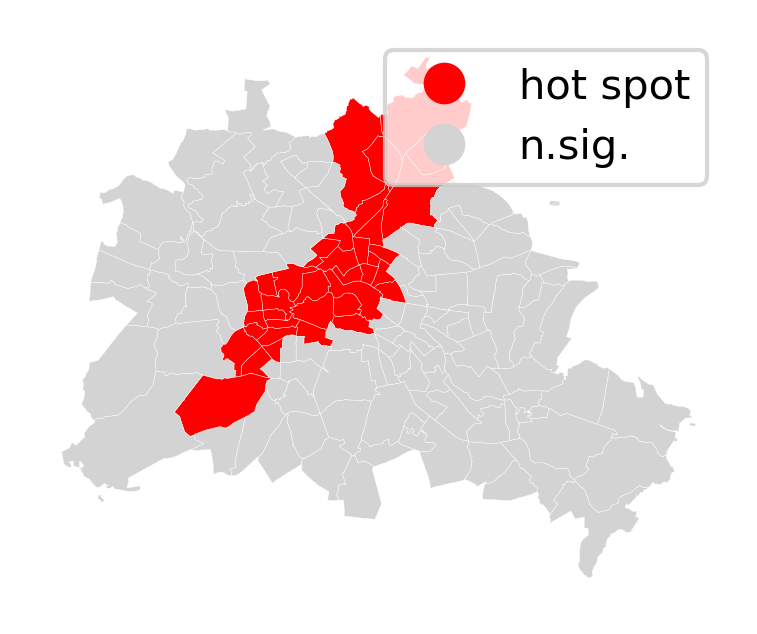

In [24]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(3, 3),dpi=300)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

- 绘制局部莫兰指数（局部自相关）中的冷点空间分布图

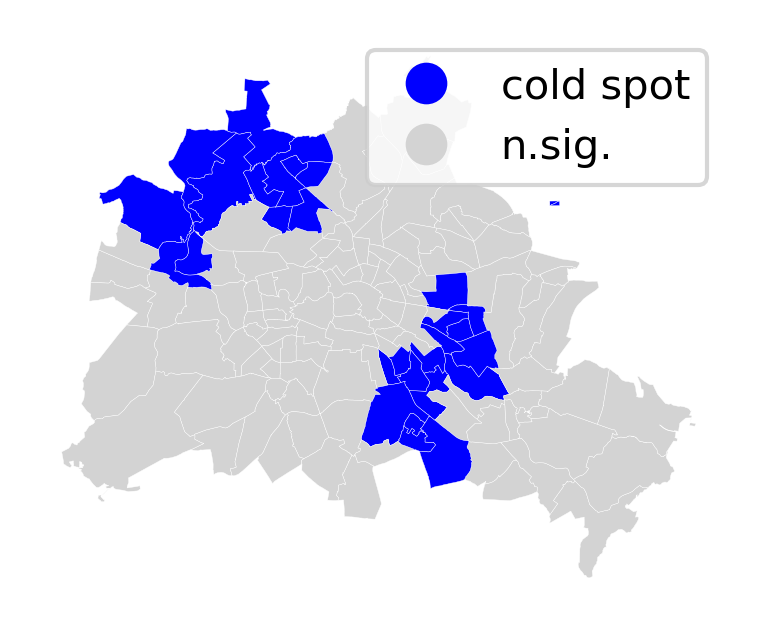

In [25]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(3, 3),dpi=300)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

- 绘制局部莫兰指数（局部自相关）中的异常值或边缘效应点(低-高)空间分布图

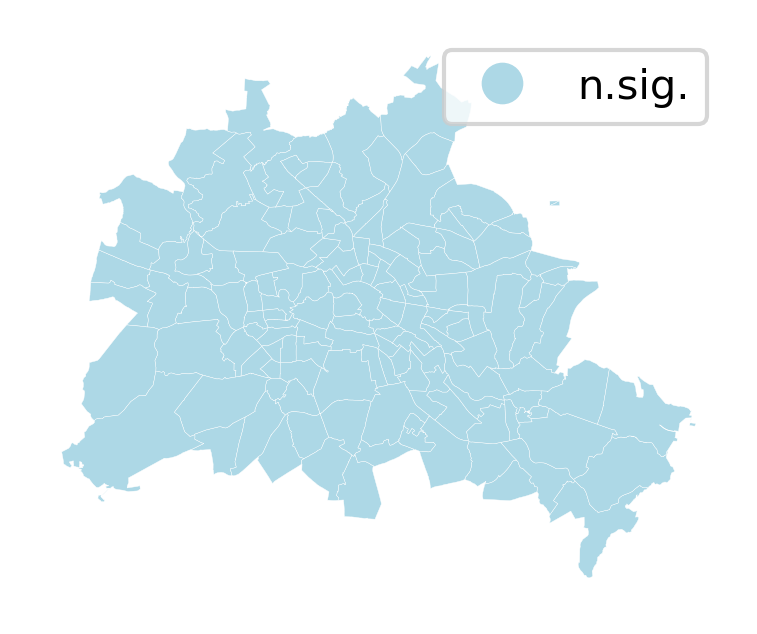

In [26]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(3, 3),dpi=300)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

- 绘制局部莫兰指数（局部自相关）中的异常值或边缘效应点(高-低)空间分布图

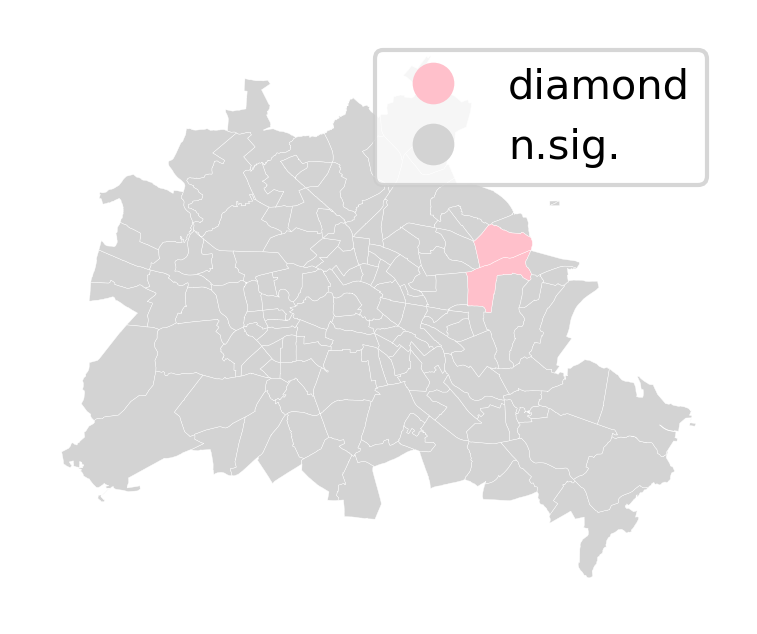

In [27]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(3, 3),dpi=300)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

- 绘制局部莫兰指数四象限的局部空间自相关的总分布图

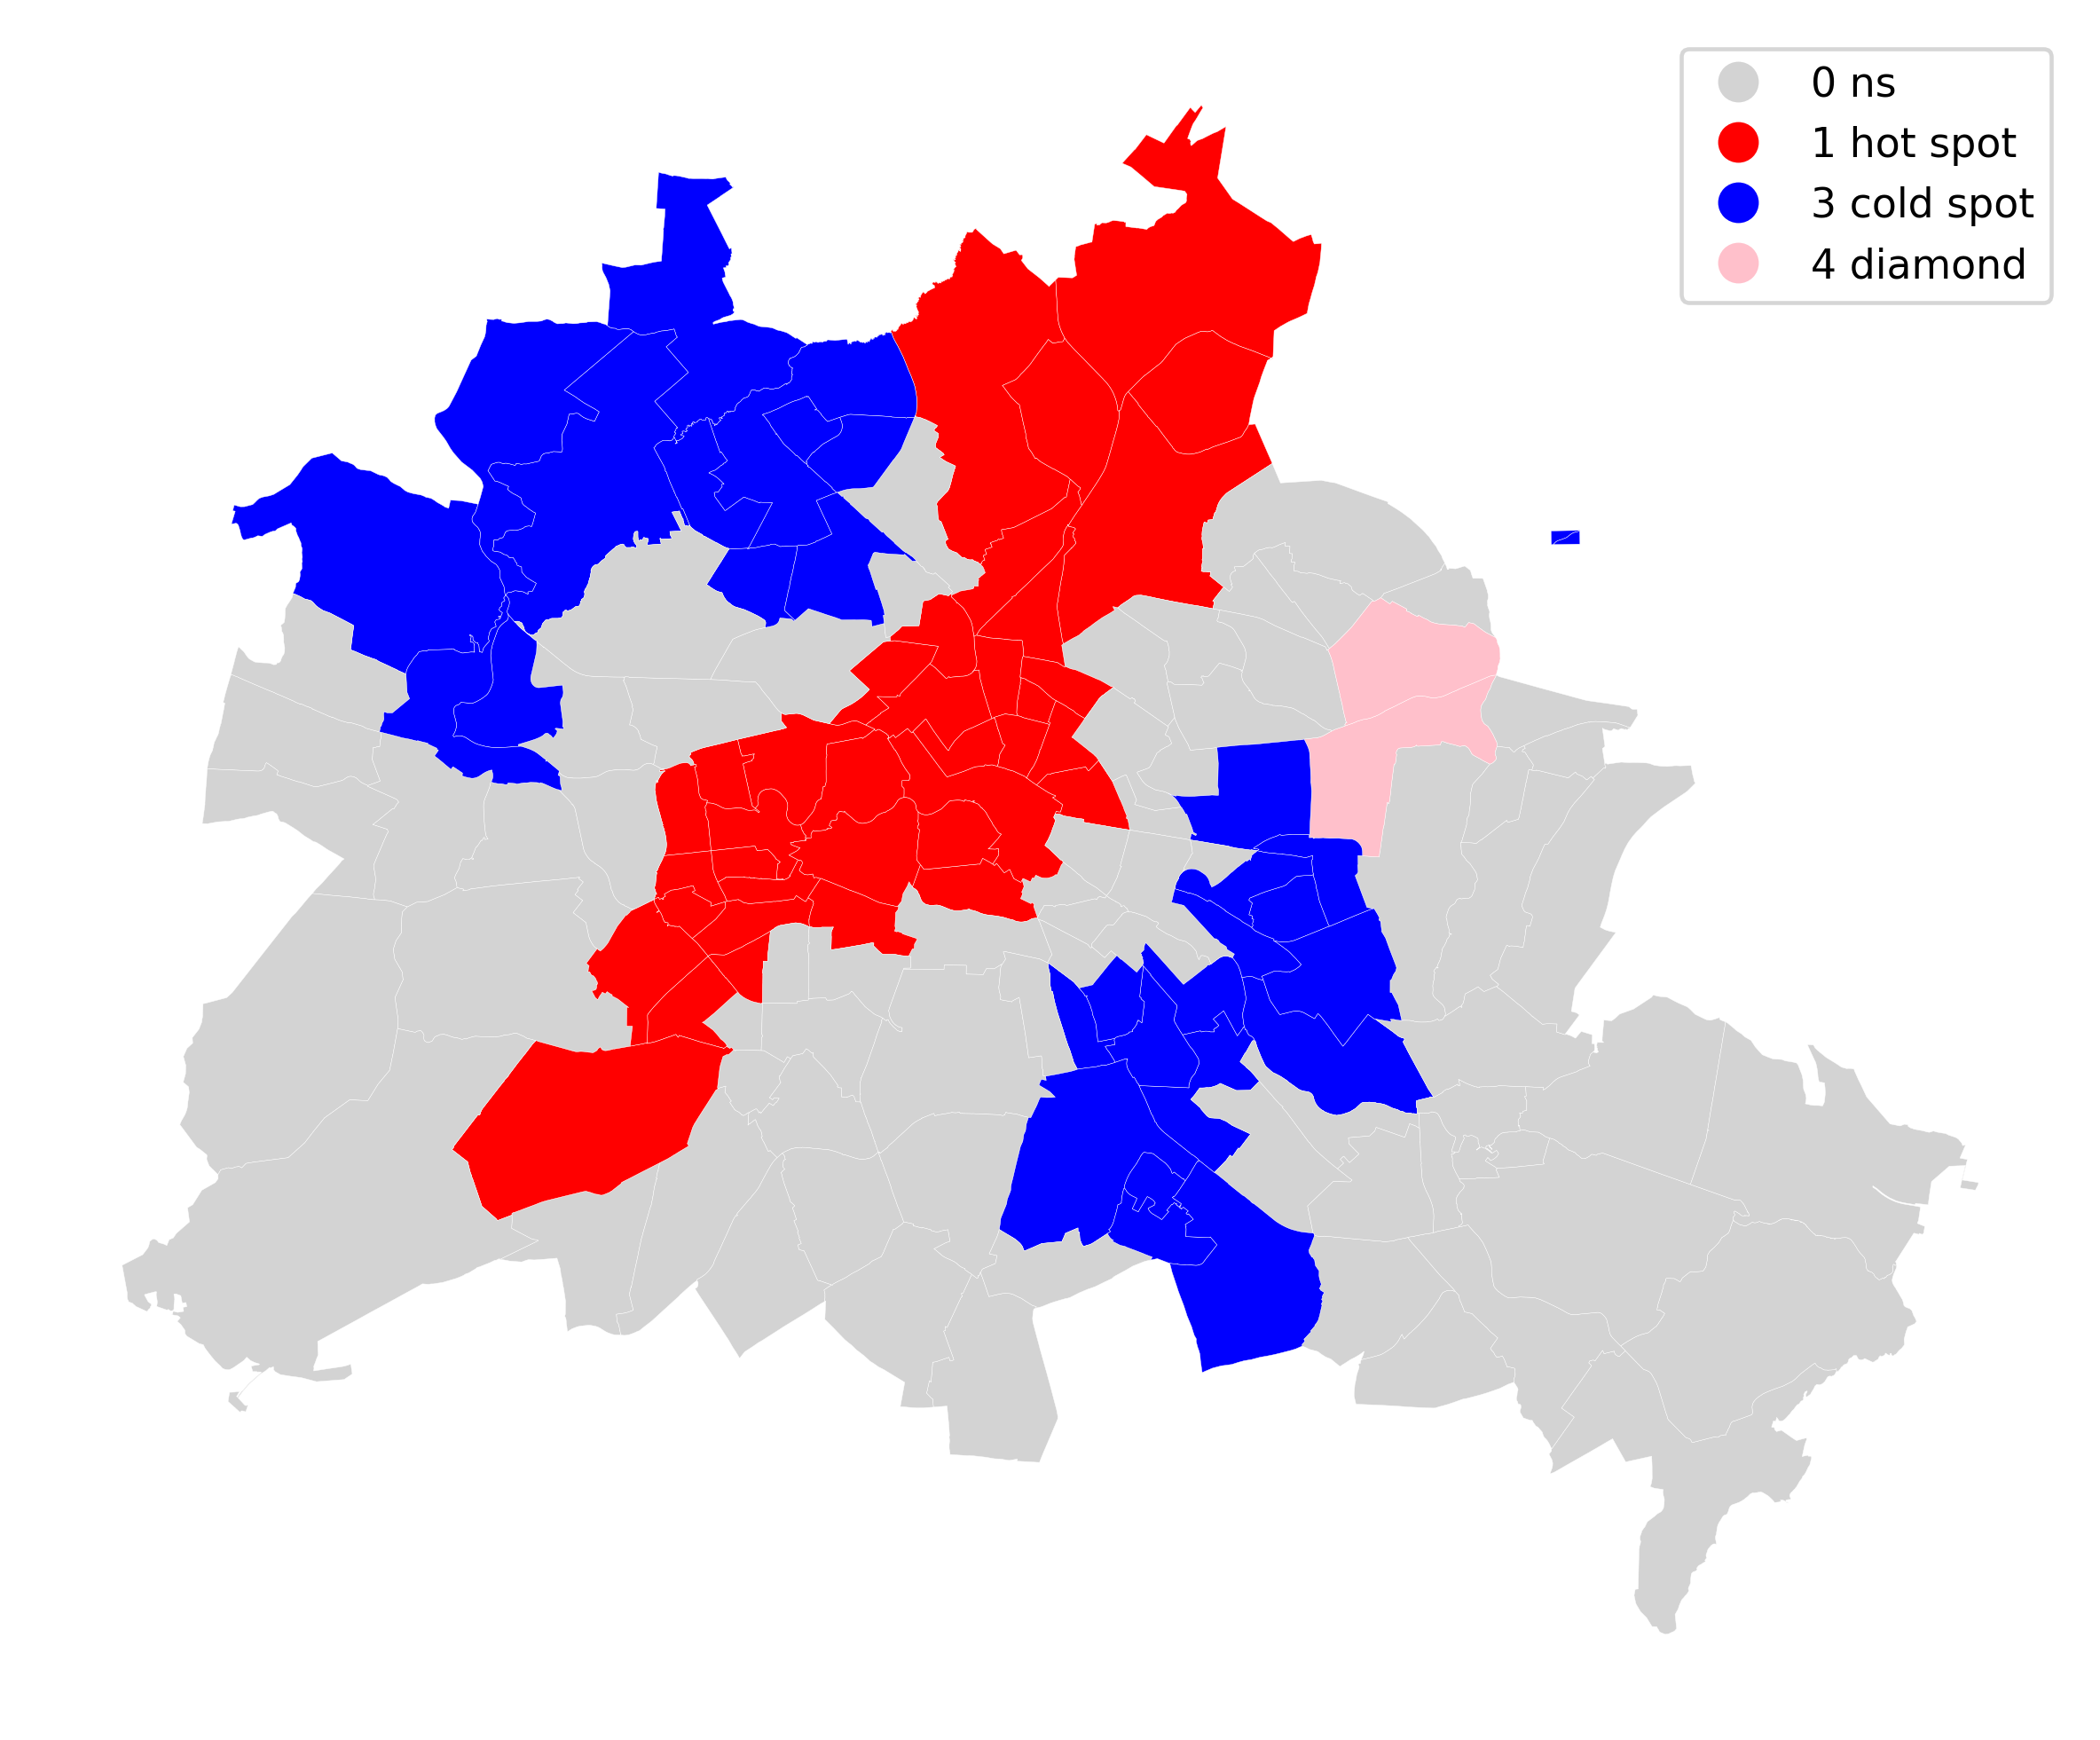

In [28]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9),dpi=330)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()
